# Overview

The goal of this project is to constructed a neural network from scratch by applying multiple least-square.

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
import math
from math import sqrt

# https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function

## Define the function

In [ ]:
def phi(u):
    y = np.tanh(u)
    return y

In [ ]:
def d_phi(u):
    d = 1/(np.cosh(u)**2)
    return d

In [ ]:
def Fnn(x,w):
    # the neural network function
    y = w[0]*phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4]) + w[5]*d_phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9]) + w[10]*d_phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14]) + w[15]
    return y

## Jacobian

The gradient of the fnn function is given by its partial derivative, as calculated below. jacobian[:,i] denotes the partial derivative of W<sub>i-1</sub> (as python begines with 0.). The jacobian is made up by [W<sub>1</sub> W<sub>2</sub>.... W<sub>16</sub>]

In [ ]:
def get_jacobian(x,w):
    jacobian = np.zeros((len(x),len(w)))
    jacobian[:,0] = phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4])
    jacobian[:,1] = w[0]*x[:,0]*d_phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4])
    jacobian[:,2] = w[0]*x[:,1]*d_phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4])
    jacobian[:,3] = w[0]*x[:,2]*d_phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4])
    jacobian[:,4] = w[0]*d_phi(w[1]*x[:,0]+w[2]*x[:,1]+w[3]*x[:,2]+w[4])
    
    jacobian[:,5] = phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9])
    jacobian[:,6] = w[5]*x[:,0]*d_phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9])
    jacobian[:,7] = w[5]*x[:,1]*d_phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9])
    jacobian[:,8] = w[5]*x[:,2]*d_phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9])
    jacobian[:,9] = w[5]*d_phi(w[6]*x[:,0]+w[7]*x[:,1]+w[8]*x[:,2]+w[9])

    jacobian[:,10] = phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14])
    jacobian[:,11] = w[10]*x[:,0]*d_phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14])
    jacobian[:,12] = w[10]*x[:,1]*d_phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14])
    jacobian[:,13] = w[10]*x[:,2]*d_phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14])
    jacobian[:,14] = w[10]*d_phi(w[11]*x[:,0]+w[12]*x[:,1]+w[13]*x[:,2]+w[14])
    
    jacobian[:,15] = 1
    
    return jacobian

## Constructing the neural network

In [ ]:
def get_weight(x,w,y,lum,lum_k):
    # a minimizer that update weight based on the previous weight
    
    jacobian = get_jacobian(x,w)
    A1 = jacobian #(500,16)
    A2 = np.identity(len(w)) #(16,16)
    A3 = np.identity(len(w)) #(16,16)
    
    b1 = (jacobian @ w) - (Fnn(x,w)-y)
    b2 = np.zeros(len(w))
    b3 = w
    
    A = np.concatenate((A1,sqrt(lum)*A2,sqrt(lum_k)*A3))
    b = np.concatenate((b1,sqrt(lum)*b2,sqrt(lum_k)*b3))
    
    update_w = inv((A.T)@A) @ (A.T) @ b
    
    return update_w

In [ ]:
def neural_net_onerun(w,x,y,lum,lum_k):
    # run the neural network without multiple run
    
    count = 0
    max_count = 20
    train_loss_array = []

    
    # Stopping when Fnn(x,w)-y is small enough
    while (np.linalg.norm(Fnn(x,w)-y) > 1) and (count<max_count) :
        w_new = get_weight(x,w,y,lum,lum_k)
    
        if ((np.linalg.norm(Fnn(x,w_new)-y)**2) + (lum)*(np.linalg.norm(w_new)**2)) < ((np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2)) :
            # accept the iterate
            w = w_new 
            train_loss = (np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2) 
            lum_k = 0.8*lum_k

        else:
            # not accept the iterate
            train_loss = (np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2)  
            lum_k = 2*lum_k
        
        
        count += 1
        train_loss_array.append(train_loss)  
    
    return w, train_loss_array, count

The stopping creteria is when the residual, Fnn(x,w)-y is smaller than 1. The k<sub>max</sub> is 20 iteration, so if the residual doesn't get to 1 before 20 turns, it will also stop. The neural network is testing without multiple run. I try out different initiation methods below and the best one will be used in construcitng the neural network with multiple run.

In [ ]:
x = np.random.rand(500,3)
y = x[:,0]*x[:,1]+x[:,2]

[59.0246686218757, 59.023489798847905, 59.02348979583977, 59.02348979583975, 59.02348979583975, 59.02348979583975, 59.02348979583975, 59.02348979583975, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974, 59.02348979583974]


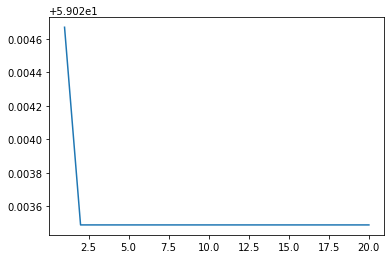

In [ ]:
w = np.zeros(16)
neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
w_final, train_loss_array, count = neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
iteration = np.arange(count)+1
plt.plot(iteration, train_loss_array)
print(train_loss_array)

Initialization will all zero vector doesn't work as the weights don't get updated and the training loss is not decreasing. Thus I try to initialize with a normal distribution with mean at 0.

[33.82500596831164, 8.364326869733041, 8.364326869733041, 8.364326869733041, 5.543859871352918, 5.184013589278458, 5.184013589278458, 5.184013589278458, 5.184013589278458, 5.184013589278458, 5.184013589278458, 5.184013589278458, 5.079867278267606, 4.924316288445828, 4.838608145781336, 4.813555183730838, 4.778597222449525, 4.638660445798875, 4.271307716209304, 3.57570023851891]


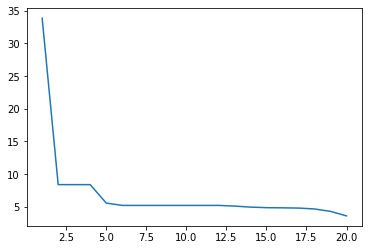

In [ ]:
w = np.random.randn(16)
neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
w_final, train_loss_array, count = neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
iteration = np.arange(count)+1
plt.plot(iteration, train_loss_array)
print(train_loss_array)

We can see from above that initialize with range only in 

[3954.176357738833, 1981.9679336812248, 1671.08183901887, 1366.5297737412927, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1232.7835190426345, 1230.195076810381]


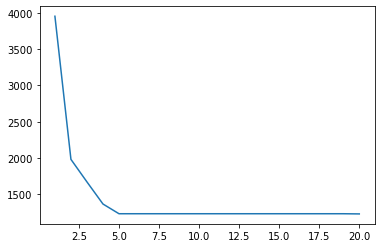

In [ ]:
w = np.random.randn(16)*10
neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
w_final, train_loss_array, count = neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
iteration = np.arange(count)+1
plt.plot(iteration, train_loss_array)
print(train_loss_array)

[795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 795.2782285083166, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581, 767.932532897581]


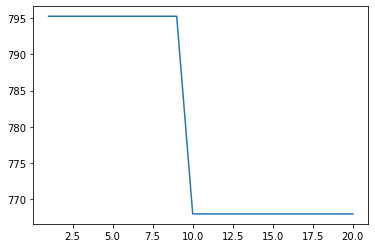

In [ ]:
w = np.random.randn(16)*100
neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
w_final, train_loss_array, count = neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
iteration = np.arange(count)+1
plt.plot(iteration, train_loss_array)
print(train_loss_array)

[82.1938412573696, 52.48350802038683, 52.48350802038683, 32.16993468258224, 32.16993468258224, 32.16993468258224, 32.16993468258224, 32.16993468258224, 21.009374367291116, 21.009374367291116, 18.746302031744694, 13.703520593694082, 8.57860992526429, 7.109380769801794, 7.0033664365268695, 5.590502605310603, 3.7471796378047557, 2.613263263304545, 2.2017653424049035, 2.2017653424049035]


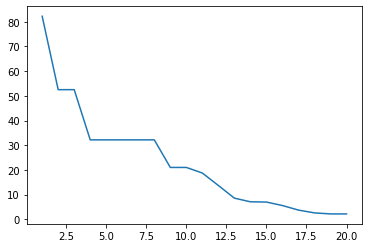

In [ ]:
w = np.random.randn(16)*0.01
neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
w_final, train_loss_array, count = neural_net_onerun(w,x,y,lum=1e-5,lum_k=1)
iteration = np.arange(count)+1
plt.plot(iteration, train_loss_array)
print(train_loss_array)

We can see that the shape of different initializations are the same, but as the initialized weights gets smaller, it has the advantages of : 1) smaller training error at start and 2) smaller variation of final training error. So I decide to initialize with w using a normal distribution multiply by 0.01 to make it small enough.

## Multiple run

The above session shows the proper initialization of w is np.random.randn(16)*0.01. Thus I'm going to perform multiple run using the same initialization. As the none of the runs achieve residual smaller than 1 before 20 runs, I use 20 runs as a fixed iteration time in the final neural network function with multiple run, so I can stack each iteration together can get the one with the smallest train loss using vectorization.

In [ ]:
def neural_net(x,y,lum,lum_k):
    multi_run_count = 0
    multi_run = 50
    max_count = 20
    
    train_loss_all = np.empty((0, max_count))
    w_all = np.empty((0, 16))
    # print(train_loss_all.shape)
    
    while multi_run_count < multi_run:
        w = np.random.randn(16)*0.01
        
        count = 0
        train_loss_one = []
        
        # (np.linalg.norm(Fnn(x,w)-y) > 1) isn't used here as different matrix size can't be stack together.
        while count<max_count :
            w_new = get_weight(x,w,y,lum,lum_k)
        
            if ((np.linalg.norm(Fnn(x,w_new)-y)**2) + (lum)*(np.linalg.norm(w_new)**2)) < ((np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2)) :
                # accept the iterate
                w = w_new 
                train_loss = (np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2) 
                lum_k = 0.8*lum_k

            else:
                # not accept the iterate
                train_loss = (np.linalg.norm(Fnn(x,w)-y)**2) + (lum)*(np.linalg.norm(w)**2)  
                lum_k = 2*lum_k
        
        
            count += 1
            train_loss_one.append(train_loss)  
            
        
        train_loss_one = np.array(train_loss_one) #(20,1)
        train_loss_one = train_loss_one.reshape(max_count,1).T #(1,20)
        multi_run_count += 1
        train_loss_all = np.concatenate((train_loss_all, train_loss_one)) #(5,20)
        w = w.reshape(1,16)
        w_all = np.concatenate((w_all, w))
        
    # print(train_loss_all)    
    min_i = np.argmin(train_loss_all[:,-1])
    train_loss_min = train_loss_all[min_i]
    w_min = w_all[min_i]
    train_loss_final = train_loss_min[-1]
    
    return w_min, train_loss_min, train_loss_final, count

In [ ]:
x = np.random.rand(500,3)
y = x[:,0]*x[:,1]+x[:,2]

The same x and y is used in the following.

### Different lumda

Text(0, 0.5, 'train_loss')

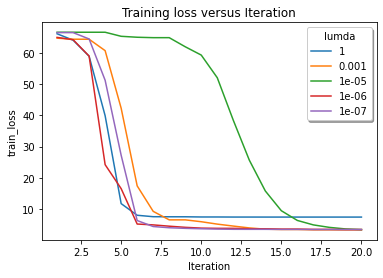

In [ ]:
# different lumda
lum = [1, 1e-3, 1e-5, 1e-6, 1e-7]

for i in lum:
    w_final, train_loss_min, train_loss_final, count = neural_net(x,y,lum=i, lum_k=1)
    iteration = np.arange(count)+1
    plt.plot(iteration, train_loss_min, label=str(i))

legend = plt.legend(title='lumda',loc='upper right', shadow=True)

plt.title('Training loss versus Iteration')
plt.xlabel('Iteration')
plt.ylabel('train_loss')

Using different lumda doesn't affect the shape of the train loss curve. There's no trend that suggest the train loss will be larger/smaller with a larger/smaller lumda. All curve converge to similar value. Thus, it seems that lumda doesn't have a strong effect on the performance of the neural network.

### Different lumda<sub>k</sub>

Text(0, 0.5, 'train_loss')

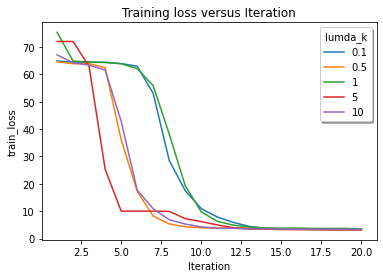

In [ ]:
# different initialization of lumda_k
lum_k = [0.1, 0.5, 1, 5, 10]

for i in lum_k:
    w_final, train_loss_min, train_loss_final, count = neural_net(x,y,lum=1e-5, lum_k=i)
    iteration = np.arange(count)+1
    plt.plot(iteration, train_loss_min, label=str(i))

legend = plt.legend(title='lumda_k',loc='upper right', shadow=True)

plt.title('Training loss versus Iteration')
plt.xlabel('Iteration')
plt.ylabel('train_loss')

Using different lumda<sub>k</sub> doesn't affect the shape of the train loss curve. There's no trend that suggest the train loss will be larger/smaller with a larger/smaller lumda<sub>k</sub>. All curve converge to similar value. Thus, it seems that lumda<sub>k</sub> doesn't have a strong effect on the performance of the neural network. 

## Training and Testing loss by different lumda and lumda<sub>k</sub>

Because the training set and testing set have different shape, I divide each loss by the number of sample contained in the set, so that I don't get smaller testing loss than training loss.

In [ ]:
def predict(testX,testY,trainX,trainY,lum,lum_k):
    w, train_loss_min, train_loss, count = neural_net(trainX,trainY,lum,lum_k)
    predictedY = Fnn(testX,w)
    n = trainX.shape[0]
    m = testX.shape[0]
    
    # normalize the loss by dividing by the size of the set
    train_loss = (1/n)*train_loss
    test_loss = (1/m)*((np.linalg.norm(predictedY-testY)**2) + (lum)*(np.linalg.norm(w)**2))
    
    return predictedY, train_loss, test_loss

In [ ]:
# different lum_k
lum_k = [0.1, 0.5, 1, 5, 10]
testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

for i in lum_k:
    predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=i)
    print('The test loss for lum_k =', i, 'is', test_loss)
    print('The train loss for lum_k =', i, 'is', train_loss, '\n')

The test loss for lum_k = 0.1 is 0.007863178137414117
The train loss for lum_k = 0.1 is 0.007320593705451723 

The test loss for lum_k = 0.5 is 0.006372294325921133
The train loss for lum_k = 0.5 is 0.006723646293462293 

The test loss for lum_k = 1 is 0.0035653925898583437
The train loss for lum_k = 1 is 0.0033947741143564017 

The test loss for lum_k = 5 is 0.00681885115173001
The train loss for lum_k = 5 is 0.006831362859119759 

The test loss for lum_k = 10 is 0.006999654092018764
The train loss for lum_k = 10 is 0.006951904646286202 



In [ ]:
# different lum
lum = [1, 1e-3, 1e-5, 1e-6, 1e-7]
testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

for i in lum:
    predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=i ,lum_k=1)
    print('The test loss for lum_k =', i, 'is', test_loss)
    print('The train loss for lum_k =', i, 'is', train_loss, '\n')

The test loss for lum_k = 1 is 0.05301596753103573
The train loss for lum_k = 1 is 0.016376114043076997 

The test loss for lum_k = 0.001 is 0.009594841283701248
The train loss for lum_k = 0.001 is 0.007218516435593448 

The test loss for lum_k = 1e-05 is 0.009487532689089341
The train loss for lum_k = 1e-05 is 0.0068770208431815135 

The test loss for lum_k = 1e-06 is 0.008735289152816713
The train loss for lum_k = 1e-06 is 0.006655576153146661 

The test loss for lum_k = 1e-07 is 0.008414807594417756
The train loss for lum_k = 1e-07 is 0.006526533386224581 



It follows the same conclusion as shown by the train loss curve that changes in these two values don't have a strong effect on the performance of the network function.

### Different N<sub>T</sub>

In [ ]:
# different N
testX = np.random.rand(50,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 50', 'is', test_loss)
print('The train loss for N = 50', 'is', train_loss, '\n')

The test loss for N = 50 is 0.12972754258623687
The train loss for N = 50 is 0.007151137078108898 



In [ ]:
testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 100', 'is', test_loss)
print('The train loss for N = 100', 'is', train_loss, '\n')

The test loss for N = 100 is 0.004111178149860293
The train loss for N = 100 is 0.006297455262726199 



In [ ]:
testX = np.random.rand(200,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 200', 'is', test_loss)
print('The train loss for N = 200', 'is', train_loss, '\n')

The test loss for N = 200 is 0.006762117300337144
The train loss for N = 200 is 0.006751055451864832 



In [ ]:
testX = np.random.rand(300,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)

print('The test loss for N = 300', 'is', test_loss)
print('The train loss for N = 300', 'is', train_loss, '\n')

The test loss for N = 300 is 0.004951998058064192
The train loss for N = 300 is 0.006916611150757653 



A larger testing set seems to have a smaller normalized loss. With same x and y, the variation of the training loss comes from different initial weights in multiple runs.

## Another function

All the codes are the same and the same neural network is applied. The only difference is the way that defines Y. In this second function, y=(x<sub>1</sub>^2)x<sub>2</sub>+x<sub>2</sub>x<sub>3</sub>.

In [ ]:
x = np.random.rand(500,3)
y = (x[:,0]**2)*x[:,1] + x[:,1]*x[:,2]

Text(0, 0.5, 'train_loss')

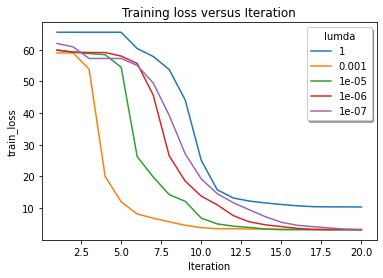

In [ ]:
# different lumda
lum = [1, 1e-3, 1e-5, 1e-6, 1e-7]

for i in lum:
    w_final, train_loss_min, train_loss_final, count = neural_net(x,y,lum=i, lum_k=1)
    iteration = np.arange(count)+1
    plt.plot(iteration, train_loss_min, label=str(i))

legend = plt.legend(title='lumda',loc='upper right', shadow=True)

plt.title('Training loss versus Iteration')
plt.xlabel('Iteration')
plt.ylabel('train_loss')

Text(0, 0.5, 'train_loss')

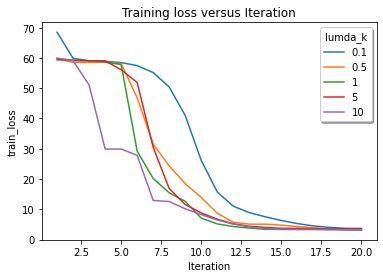

In [ ]:
# different initialization of lumda_k
lum_k = [0.1, 0.5, 1, 5, 10]

for i in lum_k:
    w_final, train_loss_min, train_loss_final, count = neural_net(x,y,lum=1e-5, lum_k=i)
    iteration = np.arange(count)+1
    plt.plot(iteration, train_loss_min, label=str(i))

legend = plt.legend(title='lumda_k',loc='upper right', shadow=True)

plt.title('Training loss versus Iteration')
plt.xlabel('Iteration')
plt.ylabel('train_loss')

In [ ]:
# different lum_k
lum_k = [0.1, 0.5, 1, 5, 10]
testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

for i in lum_k:
    predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=i)
    print('The test loss for lum_k =', i, 'is', test_loss)
    print('The train loss for lum_k =', i, 'is', train_loss, '\n')

The test loss for lum_k = 0.1 is 0.13066660736599978
The train loss for lum_k = 0.1 is 0.007813646207400809 

The test loss for lum_k = 0.5 is 0.14518867777685945
The train loss for lum_k = 0.5 is 0.007435724971629694 

The test loss for lum_k = 1 is 0.13598072774364842
The train loss for lum_k = 1 is 0.006897276503604391 

The test loss for lum_k = 5 is 0.1328860818614327
The train loss for lum_k = 5 is 0.0064956624552979046 

The test loss for lum_k = 10 is 0.14155157400309423
The train loss for lum_k = 10 is 0.0066094867174890095 



In [ ]:
# different lum
lum = [1, 1e-3, 1e-5, 1e-6, 1e-7]
testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

for i in lum:
    predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=i ,lum_k=1)
    print('The test loss for lum_k =', i, 'is', test_loss)
    print('The train loss for lum_k =', i, 'is', train_loss, '\n')

The test loss for lum_k = 1 is 0.2458128681592488
The train loss for lum_k = 1 is 0.020998302123190715 

The test loss for lum_k = 0.001 is 0.1815789017218947
The train loss for lum_k = 0.001 is 0.008392952070240723 

The test loss for lum_k = 1e-05 is 0.1937712812532741
The train loss for lum_k = 1e-05 is 0.007826241652786928 

The test loss for lum_k = 1e-06 is 0.1985073381175571
The train loss for lum_k = 1e-06 is 0.007252785725176227 

The test loss for lum_k = 1e-07 is 0.15266734985511446
The train loss for lum_k = 1e-07 is 0.00655777936926814 



In [ ]:
# different N
testX = np.random.rand(50,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 50', 'is', test_loss)
print('The train loss for N = 50', 'is', train_loss, '\n')

testX = np.random.rand(100,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 100', 'is', test_loss)
print('The train loss for N = 100', 'is', train_loss, '\n')

testX = np.random.rand(200,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)
print('The test loss for N = 200', 'is', test_loss)
print('The train loss for N = 200', 'is', train_loss, '\n')

testX = np.random.rand(300,3)
testY = testX[:,0]*testX[:,1]+testX[:,2]

predictedY, train_loss, test_loss = predict(testX,testY,x,y, lum=1e-5 ,lum_k=1)

print('The test loss for N = 300', 'is', test_loss)
print('The train loss for N = 300', 'is', train_loss, '\n')

The test loss for N = 50 is 0.14859727144403526
The train loss for N = 50 is 0.008969251562782063 

The test loss for N = 100 is 0.15226532102262882
The train loss for N = 100 is 0.006548678255853991 

The test loss for N = 200 is 0.16575532980494972
The train loss for N = 200 is 0.006147769190846043 

The test loss for N = 300 is 0.1311612022753853
The train loss for N = 300 is 0.006909290039167565 



The training curve doesn't show much difference in the second function. All the conclusion regarding different lumda, different lumda<sub>k</sub> and different N<sub>T</sub> also hold for this second function. The value of the training loss is similar compare to the first one, but the testing loss is significantly larger. It may show that the performance of the neural network decreases with more complex functions. As this project we're only using one layer, multiple layers probably will solve more complex functions better.